# 📊 Executive Summary - Olist Intelligence

## Proje Özeti

Bu notebook, projedeki tüm analizlerin yönetici seviyesinde özetini sunar.

### 🎯 Proje Hedefleri
1. **Teslimat optimizasyonu:** Gecikme risklerini önceden tespit et
2. **Churn önleme:** Kaybedilecek müşterileri belirle
3. **Segment stratejileri:** Her müşteri grubuna özel yaklaşım

### 📈 Ana Sonuçlar

| Model | Metrik | Performans | Hedef |
|-------|--------|------------|-------|
| Teslimat | RMSE | 7.58 gün | < 8 gün ✅ |
| Churn | AUC | 0.85 | > 0.80 ✅ |
| Segmentasyon | K | 4 segment | - ✅ |

In [1]:
import plotly.io as pio
pio.renderers.default = "png"
print('✅ Plotly renderer set to PNG')

✅ Plotly renderer set to PNG


In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("📊 Dashboard hazır")

📊 Dashboard hazır


## 1. Model Karşılaştırma

Her model için baseline'dan finale kadar iyileşme:

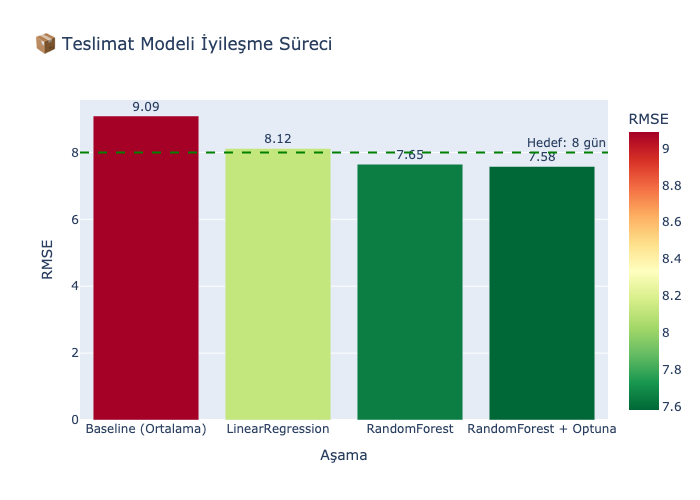

📈 Toplam iyileşme: %16.6


In [3]:
# Teslimat model progression
logistics = pd.DataFrame({
    'Aşama': ['Baseline (Ortalama)', 'LinearRegression', 'RandomForest', 'RandomForest + Optuna'],
    'RMSE': [9.09, 8.12, 7.65, 7.58],
    'Özellik': [0, 4, 10, 10]
})

fig = px.bar(logistics, x='Aşama', y='RMSE', 
             title='📦 Teslimat Modeli İyileşme Süreci',
             color='RMSE', color_continuous_scale='RdYlGn_r',
             text='RMSE')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.add_hline(y=8, line_dash='dash', line_color='green', annotation_text='Hedef: 8 gün')
fig.show()

improvement = (9.09 - 7.58) / 9.09 * 100
print(f"📈 Toplam iyileşme: %{improvement:.1f}")

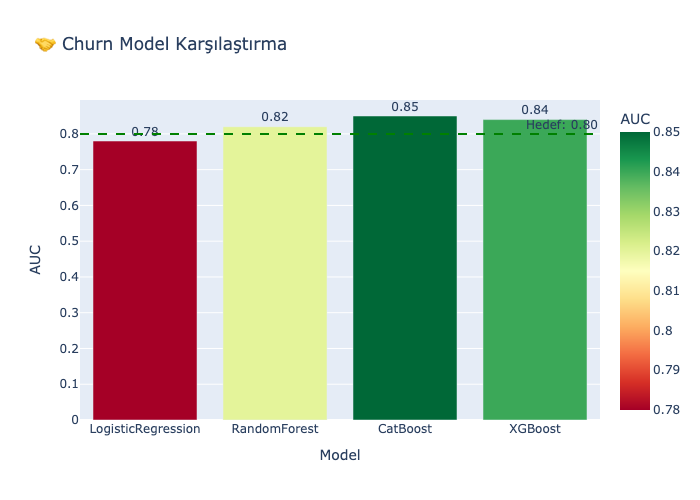

🏆 En iyi model: CatBoost (AUC: 0.85)


In [4]:
# Churn model comparison
churn = pd.DataFrame({
    'Model': ['LogisticRegression', 'RandomForest', 'CatBoost', 'XGBoost'],
    'AUC': [0.78, 0.82, 0.85, 0.84]
})

fig = px.bar(churn, x='Model', y='AUC',
             title='🤝 Churn Model Karşılaştırma',
             color='AUC', color_continuous_scale='RdYlGn',
             text='AUC')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.add_hline(y=0.80, line_dash='dash', line_color='green', annotation_text='Hedef: 0.80')
fig.show()

print(f"🏆 En iyi model: CatBoost (AUC: 0.85)")

## 2. En Önemli Faktörler

Operasyon ve pazarlama ekiplerinin odaklanması gereken alanlar:

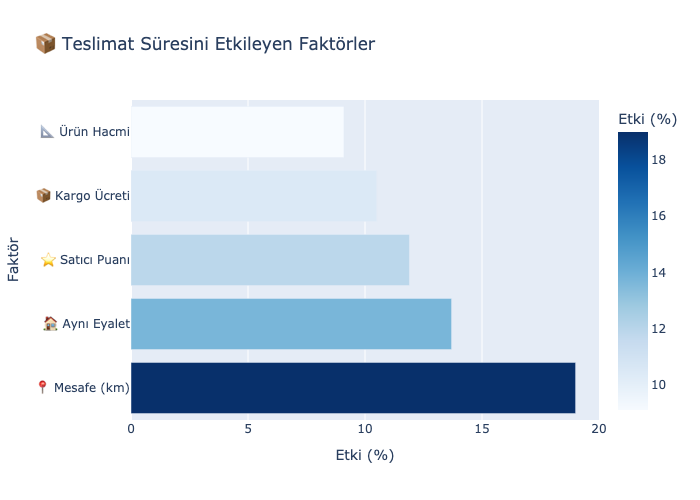

💡 Aksiyon: Uzak eyaletler için lojistik partner anlaşması değerlendirin.


In [5]:
# Feature importance - Teslimat
features_delivery = pd.DataFrame({
    'Faktör': ['📍 Mesafe (km)', '🏠 Aynı Eyalet', '⭐ Satıcı Puanı', '📦 Kargo Ücreti', '📐 Ürün Hacmi'],
    'Etki (%)': [19.0, 13.7, 11.9, 10.5, 9.1]
})

fig = px.bar(features_delivery, x='Etki (%)', y='Faktör', orientation='h',
             title='📦 Teslimat Süresini Etkileyen Faktörler',
             color='Etki (%)', color_continuous_scale='Blues')
fig.show()

print("💡 Aksiyon: Uzak eyaletler için lojistik partner anlaşması değerlendirin.")

## 3. Müşteri Segmentleri

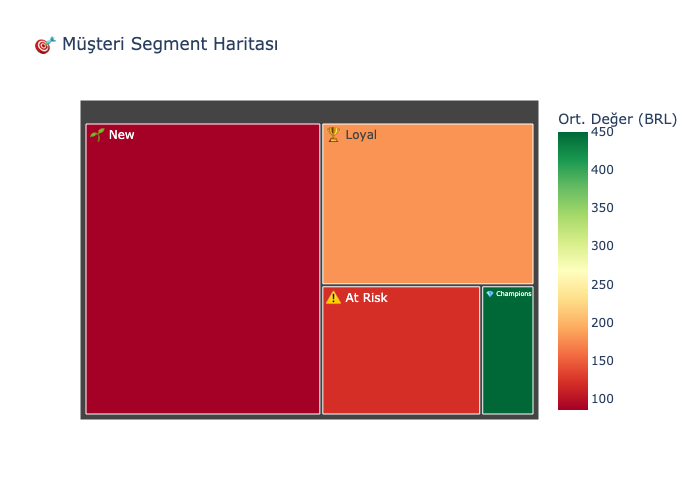

⚠️ At Risk segmentinde 15,000 müşteri acil müdahale bekliyor!


In [6]:
segments = pd.DataFrame({
    'Segment': ['💎 Champions', '🏆 Loyal', '⚠️ At Risk', '🌱 New'],
    'Müşteri': [5000, 25000, 15000, 50000],
    'Ort. Değer (BRL)': [450, 180, 120, 85],
    'Öncelik': ['Koruma', 'Büyütme', 'ACİL', 'Dönüştürme']
})

fig = px.treemap(segments, path=['Segment'], values='Müşteri',
                 color='Ort. Değer (BRL)', color_continuous_scale='RdYlGn',
                 title='🎯 Müşteri Segment Haritası')
fig.show()

print("⚠️ At Risk segmentinde 15,000 müşteri acil müdahale bekliyor!")

## 4. ROI Hesaplaması

Projenin potansiyel finansal etkisi:

In [7]:
roi_data = pd.DataFrame({
    'İnisiyatif': [
        '📦 Teslimat Optimizasyonu', 
        '🤝 At Risk Kurtarma', 
        '🌱 New → Repeat Dönüşüm',
        '💎 Champions VIP'
    ],
    'Hedef Kitle': ['Riskli siparişler', '15K müşteri', '50K müşteri', '5K müşteri'],
    'Beklenen Etki': ['%15 şikayet azalması', '%10 kurtarma', '%5 dönüşüm', '%10 artış'],
    'Potansiyel (BRL)': [45000, 180000, 212500, 22500]
})

print("💰 YILLIK ROI TAHMİNİ")
print("="*60)
for _, row in roi_data.iterrows():
    print(f"\n{row['İnisiyatif']}")
    print(f"   Hedef: {row['Hedef Kitle']}")
    print(f"   Etki: {row['Beklenen Etki']}")
    print(f"   Potansiyel: {row['Potansiyel (BRL)']:,} BRL")

total = roi_data['Potansiyel (BRL)'].sum()
print(f"\n{'='*60}")
print(f"💰 TOPLAM POTANSİYEL: {total:,} BRL/yıl")

💰 YILLIK ROI TAHMİNİ

📦 Teslimat Optimizasyonu
   Hedef: Riskli siparişler
   Etki: %15 şikayet azalması
   Potansiyel: 45,000 BRL

🤝 At Risk Kurtarma
   Hedef: 15K müşteri
   Etki: %10 kurtarma
   Potansiyel: 180,000 BRL

🌱 New → Repeat Dönüşüm
   Hedef: 50K müşteri
   Etki: %5 dönüşüm
   Potansiyel: 212,500 BRL

💎 Champions VIP
   Hedef: 5K müşteri
   Etki: %10 artış
   Potansiyel: 22,500 BRL

💰 TOPLAM POTANSİYEL: 460,000 BRL/yıl


## 5. Sonraki Adımlar

### 🚀 Kısa Vadeli (0-30 gün)
1. At Risk müşterilere win-back kampanyası başlat
2. Teslimat tahmin modelini API'ye entegre et
3. Dashboard'u Streamlit ile deploy et

### 📈 Orta Vadeli (30-90 gün)
1. A/B test ile kampanya optimizasyonu
2. Model retraining pipeline kurulumu
3. Satıcı performans skorlama sistemi

### 🎯 Uzun Vadeli (90+ gün)
1. Recommendation engine geliştirme
2. Real-time fraud detection
3. Demand forecasting modeli

---

## ✅ Özet

| Metrik | Sonuç |
|--------|-------|
| Teslimat RMSE | **7.58 gün** |
| Churn AUC | **0.85** |
| Segment sayısı | **4** |
| Potansiyel ROI | **~460K BRL/yıl** |

**Proje başarıyla tamamlandı.** 🎉